### Importing libraries

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
  At

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
from datetime import datetime
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, Accuracy, MeanIoU
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

### Connecting with Google Drive and paths setting

In [ ]:
# Mount the google drive in notebook sources
drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/data/processed" "/content/data/"

# Base path to the processed HRSID data
# base_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/data/processed'

# Base path to the processed HRSID data
base_path = '/content/data/'

# Path to all saved models
models_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models'

Mounted at /content/drive


## Model preparation & training

### Defining the data generator

In [ ]:
class SARDataGenerator(Sequence):
    """
    Data generator for loading and processing images and masks on the fly.
    This class is derived from Keras's Sequence class to efficiently handle
    batching in multi-threaded environments.
    """

    def __init__(self, image_filenames, masks_filenames, batch_size, target_size, augmentations=None):
        """
        Initialize the data generator instance.
        """
        self.image_filenames = image_filenames
        self.masks_filenames = masks_filenames
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations

        if augmentations is not None:
            self.datagen = ImageDataGenerator(**augmentations)
        else:
            self.datagen = ImageDataGenerator()

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        """
        Generate one batch of data.
        """
        # Slice the file paths to generate the batch
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Load and process the images and masks
        images = [self.process_image(file_name) for file_name in batch_x]
        masks = [self.process_mask(file_name) for file_name in batch_y]

        # Augment the images and masks
        seed = np.random.randint(0, 10000)
        images = next(self.datagen.flow(np.array(images), batch_size=self.batch_size, seed=seed))
        masks = next(self.datagen.flow(np.array(masks), batch_size=self.batch_size, seed=seed))

        return images, masks

    def process_image(self, file_name):
        """
        Load and process an image file.
        """
        # Load the image, resize it, and convert to grayscale if necessary
        if len(self.target_size) == 3 and self.target_size[2] == 3:
            image = load_img(file_name, target_size=self.target_size, color_mode='rgb')
        else:
            image = load_img(file_name, target_size=self.target_size, color_mode='grayscale')
        # Convert the image to a numpy array and normalize it to [0, 1]
        image = img_to_array(image) / 255.0

        return image

    def process_mask(self, file_name):
        """
        Load and process a mask file.
        """
        # Load the mask, resize it, and convert to grayscale
        mask = load_img(file_name, target_size=self.target_size, color_mode="grayscale")
        # Convert the mask to a numpy array and normalize it  to [0, 1]
        mask = img_to_array(mask) / 255.0

        return mask


### Defining the U-Net model

In [ ]:
def conv_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation="relu")(input_tensor)
    x = BatchNormalization()(x)
    # second layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with max pooling and dropout"""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    p = Dropout(0.1)(p)  # Dropout for regularization
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Function to add upsampling layer, concatenate the input from corresponding encoder block, followed by 2 convolutional layers"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = concatenate([x, concat_tensor])  # Skip connection
    x = Dropout(0.1)(x)  # Dropout for regularization
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """Function to build the U-Net model"""
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # Bridge
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)

    # Output
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(d4)

    model = Model(inputs, outputs, name='U-Net')
    return model

### Defining los function

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

### Creating directory for model data

In [ ]:
# Create a timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# Combine the models path with the timestamp
model_dir = os.path.join(models_path, f'Sesja z {timestamp}')
# Create the directory
os.makedirs(model_dir, exist_ok=True)
print(f"New directory created: {model_dir}")

New directory created: /content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-17_19-40-10


### Defining callbacks

In [ ]:
callback_1 = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'unet_best_val_loss.keras'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callback_2 = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_val_precision.keras"),
    monitor='val_precision',
    mode='max',
    save_best_only=True,
    verbose=1
)

callback_3 = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_val_recall.keras"),
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=1
)

callback_4 = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_val_accuracy.keras"),
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callback_5 = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_val_iou.keras"),
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=True,
    verbose=1
)

### Defining training parameters

In [ ]:
N_CLASSES = 2
LEARNING_RATE = 1e-4
TARGET_SHAPE = (512, 512, 1)
BATCH_SIZE = 8
EPOCHS = 20

### Building U-Net model

In [ ]:
opti = Adam(learning_rate=LEARNING_RATE)

model = build_unet(TARGET_SHAPE)
model.compile(optimizer='adam', loss=dice_loss, metrics=[Precision(), Recall(), Accuracy(), MeanIoU(num_classes=N_CLASSES)])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['batch_normalization[0][0

### Creating generator objects

In [ ]:
train_images_dir = os.path.join(base_path, 'train', 'images')
train_masks_dir = os.path.join(base_path, 'train', 'masks')
train_images = [os.path.join(train_images_dir, f) for f in sorted(os.listdir(train_images_dir))]
train_masks = [os.path.join(train_masks_dir, f) for f in sorted(os.listdir(train_masks_dir))]

val_images_dir = os.path.join(base_path, 'val', 'images')
val_masks_dir = os.path.join(base_path, 'val', 'masks')
val_images = [os.path.join(val_images_dir, f) for f in sorted(os.listdir(val_images_dir))]
val_masks = [os.path.join(val_masks_dir, f) for f in sorted(os.listdir(val_masks_dir))]

augmentations = {
    'rotation_range': 10,              # Small rotations
    'width_shift_range': 0.05,         # Slight horizontal shifts
    'height_shift_range': 0.05,        # Slight vertical shifts
    'zoom_range': [0.75, 1.0],         # Small zooms in
    'horizontal_flip': True,           # Horizontal flips (if applicable)
    'vertical_flip': True,             # Vertical flips (if applicable)
    'fill_mode': 'constant'            # Fill mode for new pixels
}

train_gen = SARDataGenerator(image_filenames=train_images, masks_filenames=train_masks, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE, augmentations=augmentations)
val_gen = SARDataGenerator(image_filenames=val_images, masks_filenames=val_masks, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE)

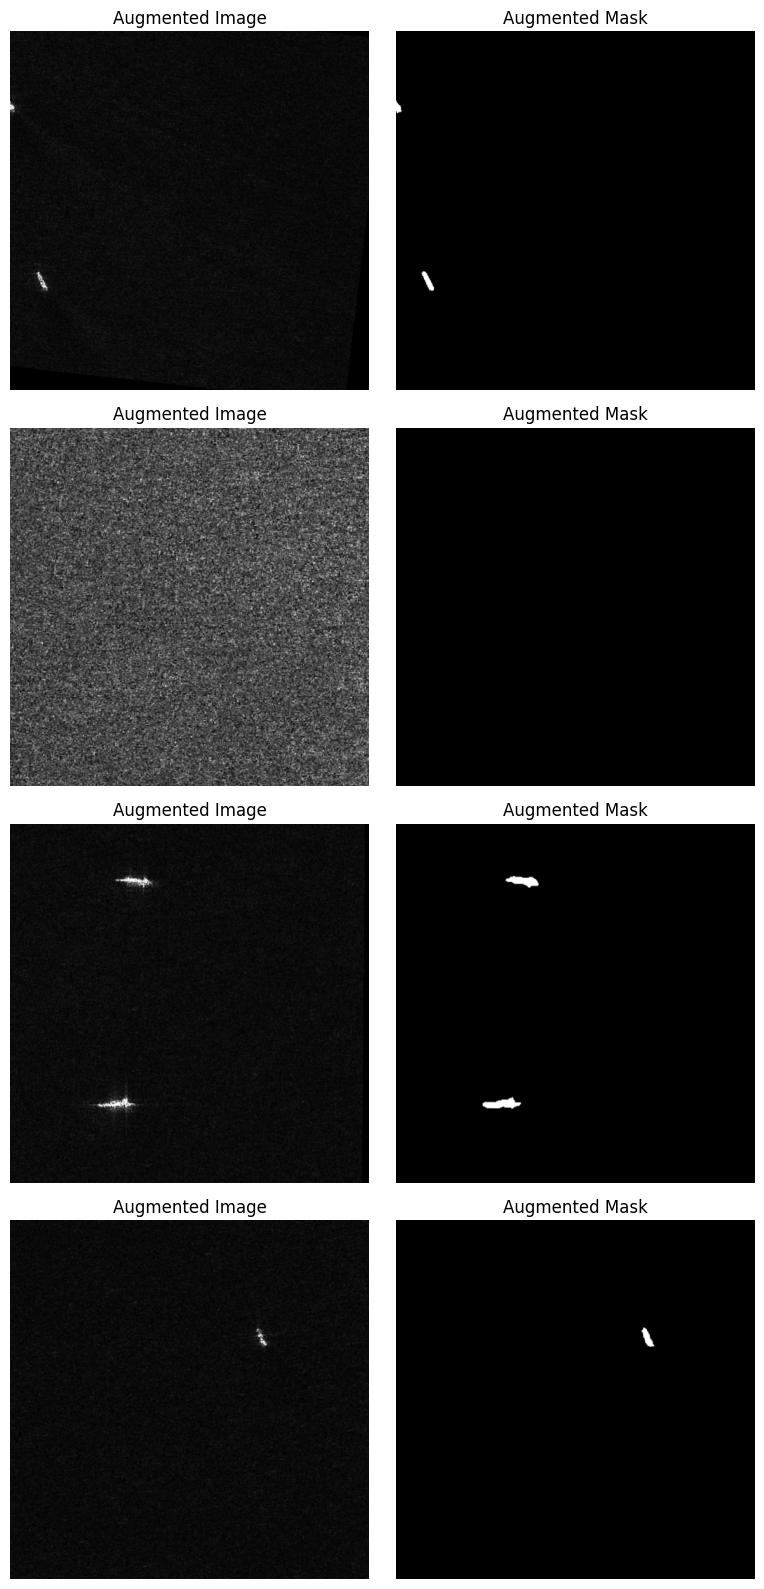

In [ ]:
# Function to visualize a few random augmented images and masks
def visualize_augmentations(generator, num_samples=4):
    images, masks = generator.__getitem__(101)  # Get the first batch

    plt.figure(figsize=(8, num_samples * 4))

    for i in range(num_samples):
        # Display augmented image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Augmented Image')
        plt.axis('off')

        # Display augmented mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Augmented Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the augmentations
visualize_augmentations(train_gen, num_samples=4)

### Training the model

In [ ]:
history = model.fit(train_gen,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_gen,
                    callbacks=[callback_1, callback_2, callback_3, callback_4, callback_5])

Epoch 1/20
491/491 [==============================] - ETA: 0s - loss: 0.6283 - precision: 0.0648 - recall: 0.6913 - accuracy: 0.0024 - mean_io_u: 0.5235
Epoch 1: val_loss improved from inf to 0.80405, saving model to /content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-17_19-40-10/unet_best_val_loss.keras

Epoch 1: val_precision improved from -inf to 0.60467, saving model to /content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-17_19-40-10/unet_best_val_precision.keras

Epoch 1: val_recall improved from -inf to 0.15351, saving model to /content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-17_19-40-10/unet_best_val_recall.keras

Epoch 1: val_accuracy improved from -inf to 0.00037, saving model to /content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-17_19-40-10/unet_best_val_accuracy.keras

Epoch 1: val_mean_io_u improved from -inf to 0.55031, saving model to /content/drive/MyDrive/Studia/SAR_Ship_Segme

### Saving training history

In [ ]:
with open(os.path.join(model_dir, 'training_history.pkl'), 'wb') as file:
    pickle.dump(history.history, file)

## Model evaluation

### Loading the model and history of training

In [ ]:
saved_model = model
saved_history = history.history

In [ ]:
model_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-17_19-40-10/unet_best_val_loss.keras'
history_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-08-17_19-40-10/training_history.pkl'

# Load the saved model
saved_model = load_model(model_path, custom_objects={'dice_loss': dice_loss})

# Load the saved history
with open(history_path, 'rb') as file:
    saved_history = pickle.load(file)

### Historical metrics and losses from training

In [ ]:
def plot_training_history(hist_dict):
    data_cats = list(hist_dict.keys())
    valid_data = sorted([d for d in data_cats if 'val_' in d])
    train_data = sorted([d for d in data_cats if 'val_' not in d])
    data_pairs = list(zip(train_data, valid_data)) if len(valid_data) else [(d) for d in train_data]

    for data in data_pairs:
        fig, axs = plt.subplots(figsize=(6, 5))
        fig.suptitle(f"{data[0].capitalize().replace('_', ' ')} over training epochs")
        y_values = hist_dict[data[0]]
        x_values = range(1, len(y_values) + 1)
        axs.plot(x_values, y_values, label="training", color='blue', marker='o', linewidth=2)
        if len(data) > 1:
            y_values = hist_dict[data[1]]
            axs.plot(x_values, y_values, label="validation", color='orange', marker='o', linewidth=2)
        axs.set_xlabel('epochs')
        axs.set_ylabel(f"{data[0].replace('_', ' ').lower()}")
        axs.xaxis.set_major_locator(MaxNLocator(integer=True))
        axs.legend()
        axs.grid()
        plt.show()

Data categories from model training:  ['loss', 'precision', 'recall', 'accuracy', 'mean_io_u', 'val_loss', 'val_precision', 'val_recall', 'val_accuracy', 'val_mean_io_u'] 



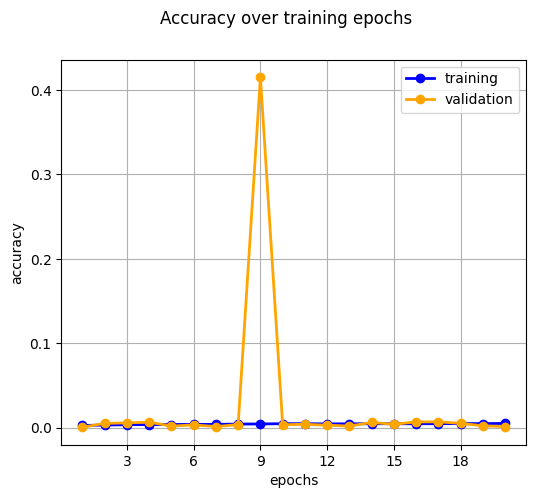

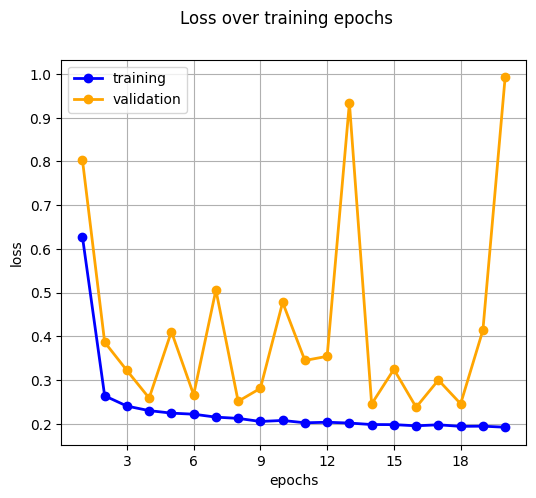

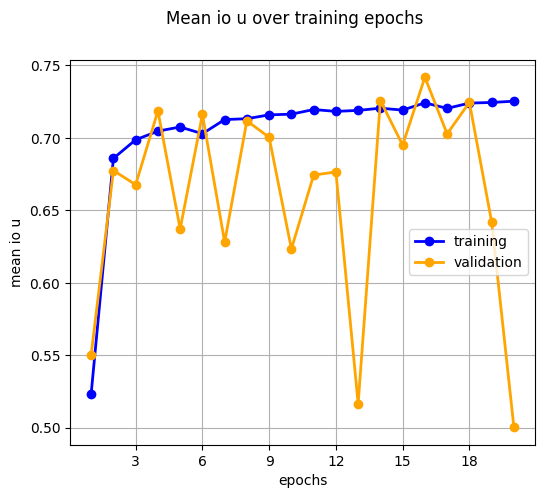

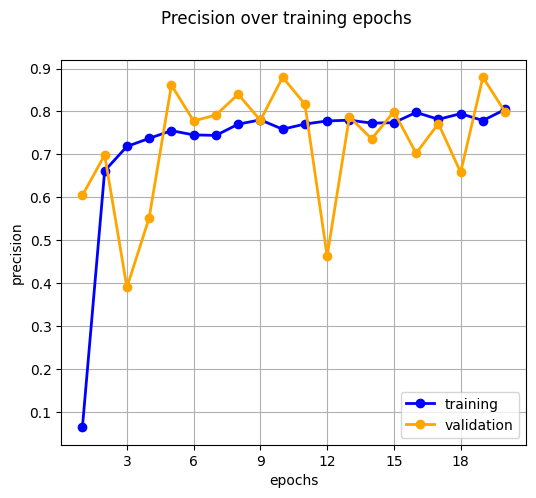

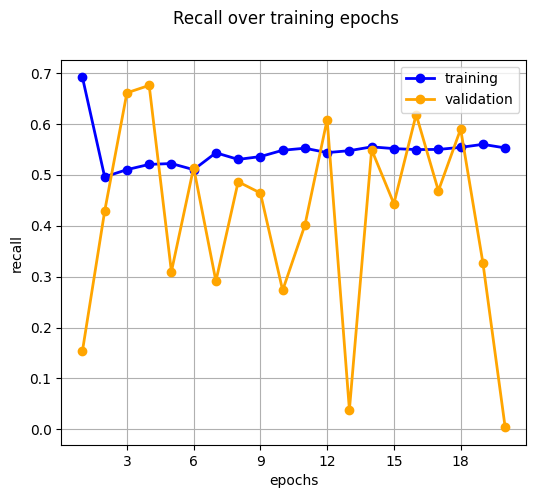

In [ ]:
print("Data categories from model training: ", list(saved_history.keys()), "\n")
plot_training_history(saved_history)

### Evaluate model (compute loss & metrics values in test mode)

In [ ]:
test_images_dir = os.path.join(base_path, 'test', 'images')
test_masks_dir = os.path.join(base_path, 'test', 'masks')
test_images = [os.path.join(test_images_dir, f) for f in sorted(os.listdir(test_images_dir))]
test_masks = [os.path.join(test_masks_dir, f) for f in sorted(os.listdir(test_masks_dir))]

test_gen = SARDataGenerator(image_filenames=test_images, masks_filenames=test_masks, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE)

test_images_loaded = np.array([test_gen.process_image(f) for f in test_images])
test_masks_loaded = np.array([test_gen.process_mask(f) for f in test_masks])

In [ ]:
results = saved_model.evaluate(test_gen, batch_size=16)
print(results)

106/106 [==============================] - 33s 301ms/step - loss: 0.2279 - precision: 0.7348 - recall: 0.5619 - accuracy: 0.0069 - mean_io_u: 0.7294
[0.22792960703372955, 0.7347968816757202, 0.5618611574172974, 0.006882003974169493, 0.7293919324874878]


In [ ]:
predictions = saved_model.predict(test_images_loaded, batch_size=16)

NameError: name 'saved_model' is not defined

### Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold
    conf_matrix = confusion_matrix(y_true.flatten(), y_pred_binary.flatten())

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
plot_confusion_matrix(test_masks_loaded[1], predictions[1], class_names=['Background', 'Ship'])

### Prediction vs. ground truth visualization

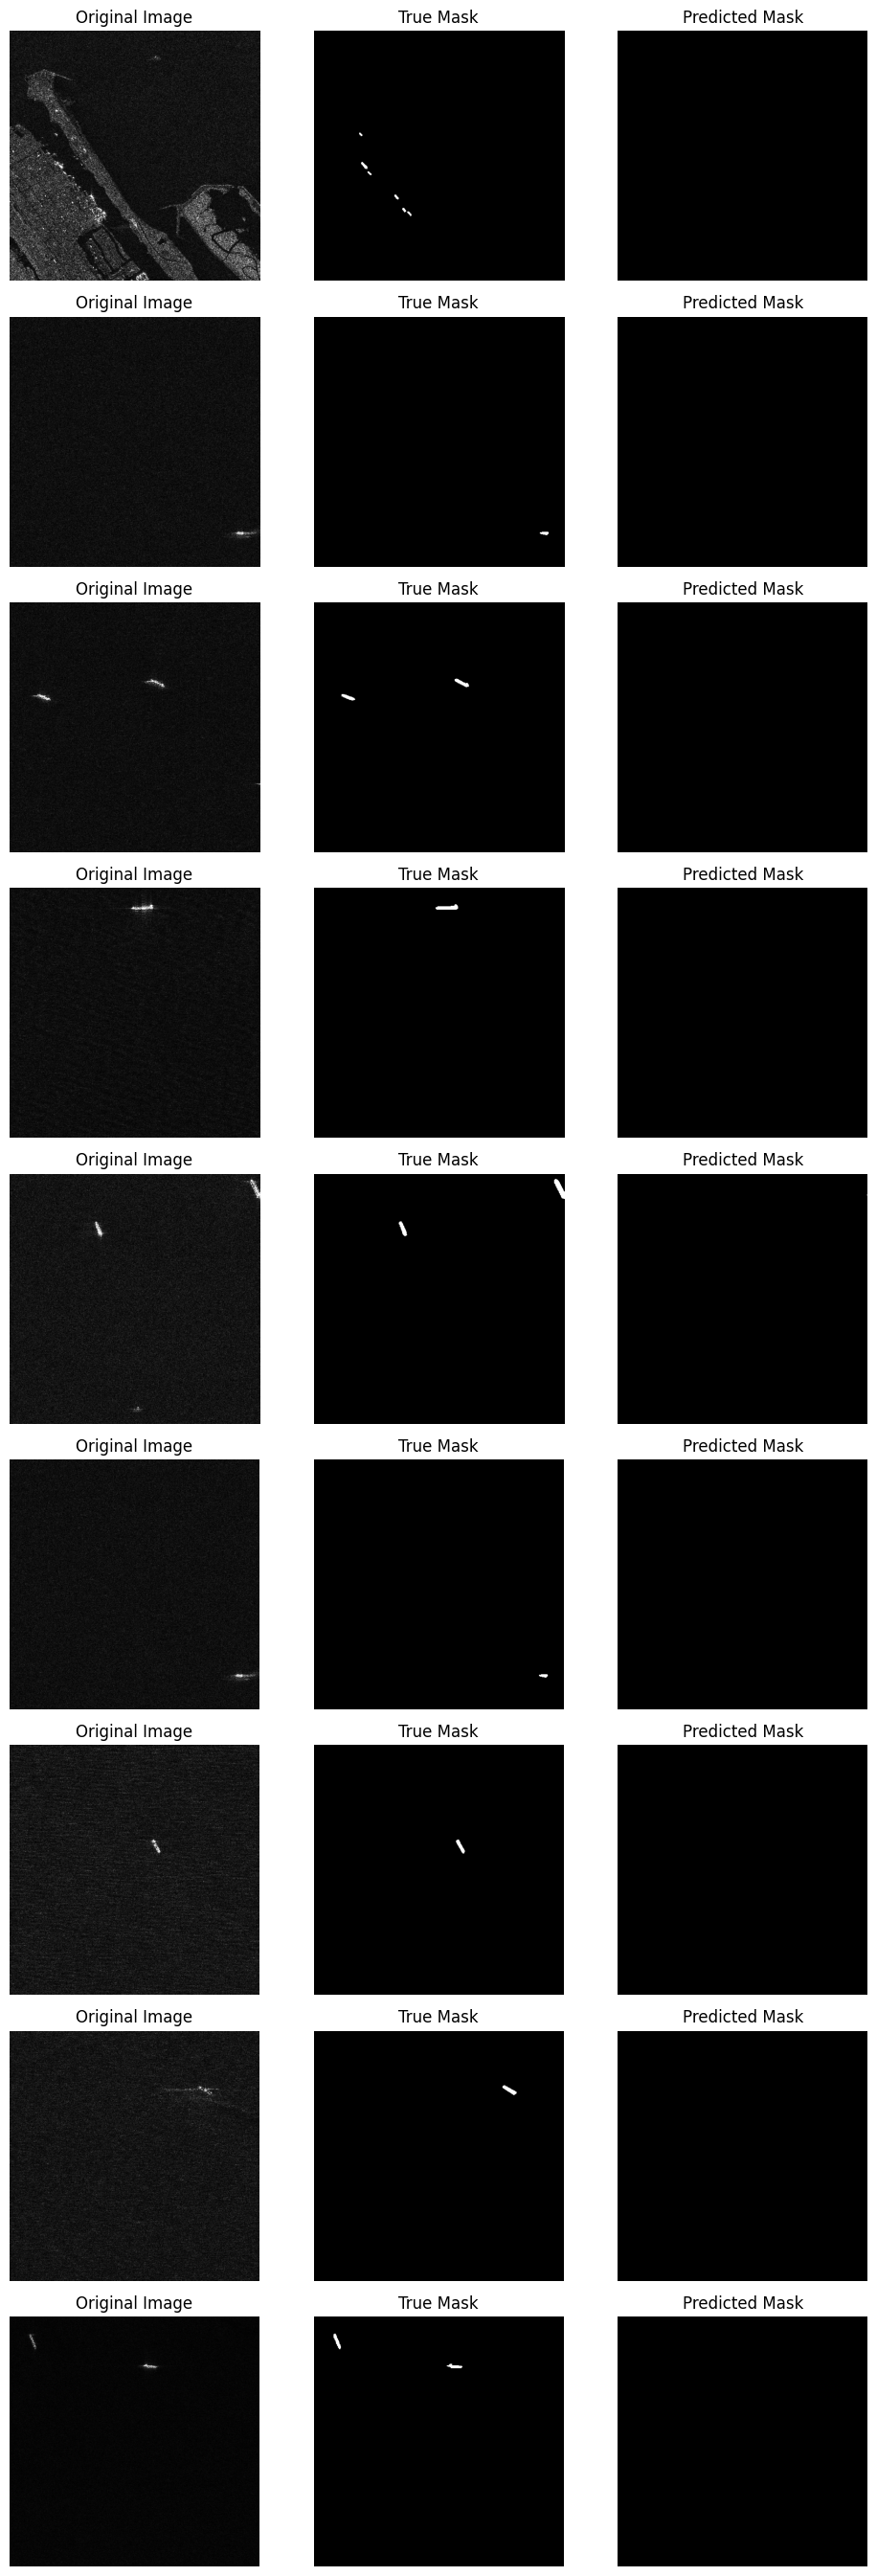

In [ ]:
def visualize_predictions(image_batch, mask_batch, prediction_batch, num_samples=3):
    # Ensure that the number of samples does not exceed the batch size
    num_samples = min(num_samples, len(image_batch))

    # Randomly select indices for the images to display
    indices = np.random.randint(0, len(image_batch), num_samples)

    fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))
    for i, idx in enumerate(indices):
        axs[i, 0].imshow(image_batch[idx, :, :, 0], cmap='gray')
        axs[i, 0].title.set_text('Original Image')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(mask_batch[idx, :, :, 0], cmap='gray')
        axs[i, 1].title.set_text('True Mask')
        axs[i, 1].axis('off')
        axs[i, 2].imshow(prediction_batch[idx, :, :, 0] > 0.5, cmap='gray')  # Thresholding prediction
        axs[i, 2].title.set_text('Predicted Mask')
        axs[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

# Assume 'predictions' contains the model's outputs for the corresponding test images
visualize_predictions(test_images_loaded, test_masks_loaded, predictions, 9)